## Julia Implementation of Host SEIR + Vector SEI

*Author*: Carl A. B. Pearson @pearsonca

*Date*: 2018-10-02

This version considers multiple hosts *and* multiple vectors, which further complicates indexing.  Now the indexing scheme is:

 - all of host $i$ compartments ($S_H^i$, $E_H^i$, etc), for each $i \in 1\ldots N$
 - all of vector $j$ compartments ($S_V^j$, $E_V^j$, etc), for each $j \in 1\ldots M$

With this approach, we can again re-use the solutions for single host and single vector, with slight modifications:

In [1]:
H_comps = 4
V_comps = 3

# in sub functions, du / u are the particular relevant slices only
function F1H(du, u, p, t, βslice, I_V, N_H)
    S_H, E_H, I_H, R_H = u
    
    # host dynamics
    host_infection = sum(βslice .* I_V)*S_H/N_H
    host_mortality = p.μ_H .* u # include S_H, so easier to remove mortality
    host_births = sum(host_mortality)
    host_progression = p.σ_H*E_H
    recovery = p.λ*I_H
    
    du[1] = -host_infection + host_births
    du[2] = host_infection - host_progression
    du[3] = host_progression - recovery
    du[4] = recovery
    du[1:end] -= host_mortality 
end

# in sub functions, du / u are the particular relevant slices only
function F1V(du, u, p, t, βslice, I_H, N_H)
    S_V, E_V, I_V = u
    vec_infection = sum(βslice .* I_H)*S_V/N_H
    vec_mortality = p.μ_V .* u # include S_V, so easier to remove mortality
    vec_births = sum(vec_mortality)
    vec_progression = p.σ_V*E_V
    
    du[1] = -vec_infection + vec_births
    du[2] = vec_infection - vec_progression
    du[3] = vec_progression
    du[1:end] -= vec_mortality
end

function F(du,u,p,t)
    dH = @view(du[1:(p.nHosts*H_comps)])
    dV = @view(du[(p.nHosts*H_comps+1):end])
    Hs = @view(u[1:(p.nHosts*H_comps)])
    Vs = @view(u[(p.nHosts*H_comps+1):end])
    
    I_Vs = @view(Vs[3:V_comps:V_comps*p.nVecs])
    I_Hs = @view(Hs[3:H_comps:H_comps*p.nHosts])
    
    for host in 0:(p.nHosts-1)
        slice = (1:H_comps).+(H_comps*host)
        F1H(@view(dH[slice]), @view(Hs[slice]), p.host[host+1], t, @view(p.β[host+1,:]), I_Vs, p.N_H)
    end
    for vec in 0:(p.nVecs-1)
        slice = (1:V_comps).+(V_comps*vec)
        F1V(@view(dV[slice]), @view(Vs[slice]), p.vec[vec+1], t, @view(p.β[:,vec+1]), I_Hs, p.N_H)
    end
end

F (generic function with 1 method)

First, state initial conditions.  This code generates them randomly for convenience, though they could be assigned based on data, desired parameter space, or algorithmically as part of a fitting process:

In [2]:
nH = 2
nV = 2
srand(0)

S_Hs = ones(nH) .* 100.0
E_Hs = zeros(nH)
I_Hs = shuffle(vcat(zeros(nH-1),[1.0]))
R_Hs = zeros(nH)
host0 = reshape(hcat(S_Hs,E_Hs,I_Hs,R_Hs)', nH*H_comps, 1)

S_Vs = ones(nV) .* 1000.0
E_Vs = zeros(nV)
I_Vs = zeros(nV)
vec0 = reshape(hcat(S_Vs,E_Vs,I_Vs)', nV*V_comps, 1)

u0 = vcat(host0, vec0)

14×1 Array{Float64,2}:
  100.0
    0.0
    1.0
    0.0
  100.0
    0.0
    0.0
    0.0
 1000.0
    0.0
    0.0
 1000.0
    0.0
    0.0

Now, generate dynamic parameters.  Again: this code generates them randomly for convenience, though they could be assigned based on data, desired parameter space, or algorithmically as part of a fitting process:

In [3]:
srand(1)

μs = 1 ./ (rand(nH) .* 360)
σs = 1 ./ (rand(nH) .* 6)
μVs = 1 ./ (rand(nV) .* 60)
σVs = 1 ./ (rand(nV) .* 14)

λs = 1 ./ (rand(nH) .* 28)
βs = rand(nH*nV) ./ 10.0

using NamedTuples
# nb: in >= Julia v0.7, can eliminate this import
#  and the @NT syntax
p = @NT(
  nHosts = nH, nVecs = nV,
  N_H = sum(host0),
  β = reshape(βs,nH,nV), # information in hosts (rows) by vectors (cols)
  vec  = [@NT(μ_V=μVs[j], σ_V=σVs[j]) for j in 1:nV],
  host = [@NT(μ_H=μs[i], σ_H=σs[i], λ=λs[i]) for i in 1:nH]
  # just building up a random collection of params for demonstration
)

(nHosts = 2, nVecs = 2, N_H = 201.0, β = [0.0555751 0.0424718; 0.0437108 0.0773223], vec = NamedTuples._NT_μ__V_σ__V{Float64,Float64}[(μ_V = 0.0341102, σ_V = 0.0750366), (μ_V = 0.0790008, σ_V = 0.0714354)], host = NamedTuples._NT_μ__H_σ__H_λ{Float64,Float64,Float64}[(μ_H = 0.0117686, σ_H = 0.53298, λ = 0.141914), (μ_H = 0.00801628, σ_H = 21.0723, λ = 0.0361969)])

Now these values can be used with the ODE solver:

In [4]:
using DifferentialEquations
using IterableTables, DataFrames

tspan = (0.0, 365.0)
prob = ODEProblem(F, u0, tspan, p)
sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8,saveat=linspace(0,365,365*10+1))

retcode: Success
Interpolation: 1st order linear
t: 3651-element Array{Float64,1}:
   0.0
   0.1
   0.2
   0.3
   0.4
   0.5
   0.6
   0.7
   0.8
   0.9
   1.0
   1.1
   1.2
   ⋮  
 363.9
 364.0
 364.1
 364.2
 364.3
 364.4
 364.5
 364.6
 364.7
 364.8
 364.9
 365.0
u: 3651-element Array{Array{Float64,2},1}:
 [100.0; 0.0; … ; 0.0; 0.0]                       
 [100.001; 1.45562e-7; … ; 0.0208111; 7.45142e-5] 
 [100.002; 1.1395e-6; … ; 0.0409938; 0.000294274] 
 [100.004; 3.76354e-6; … ; 0.0605622; 0.000653715]
 [100.005; 8.73081e-6; … ; 0.0795303; 0.00114742] 
 [100.006; 1.66901e-5; … ; 0.0979121; 0.00177011] 
 [100.007; 2.82298e-5; … ; 0.115721; 0.00251664]  
 [100.008; 4.38818e-5; … ; 0.13297; 0.00338201]   
 [100.009; 6.41252e-5; … ; 0.149673; 0.00436136]  
 [100.01; 8.93894e-5; … ; 0.165843; 0.00544994]   
 [100.012; 0.000120058; … ; 0.181491; 0.00664314] 
 [100.013; 0.000156469; … ; 0.196631; 0.00793648] 
 [100.014; 0.000198924; … ; 0.211274; 0.00932559] 
 ⋮                           

In [5]:
# rename!(df, Dict(:timestamp => :t,
#  :value1 => :S_H, :value2 => :E_H, :value3 => :I_H, :value4 => :R_H,
#  :value5 => :S_V, :value6 => :E_V, :value7 => :I_V
# ))
# mlt[:host] = contains.(string.(mlt[:variable]),"H"); # tag which entries are host vs vector
# df
df = DataFrame(sol)
mlt = melt(df,:timestamp) # convert results into long format for plotting
mlt[:index] = parse.(Int,replace.(string.(mlt[:variable]),r"[^\d]+"=>""))
namekey = hcat(
  reshape(["$(compartment)_H$species" for compartment in ["S","E","I","R"], species in 1:nH],1,:),
  reshape(["$(compartment)_V$species" for compartment in ["S","E","I"], species in 1:nV],1,:)
)

mlt[:name] = namekey[mlt[:index]]
mlt[:facet] = replace.(string.(mlt[:name]),r"\w+_"=>"")
mlt[:compartment] = replace.(string.(mlt[:name]),r"_\w+"=>"")
mlt

,variable,value,timestamp,index,name,facet,compartment
1,value1,100.0,0.0,1,S_H1,H1,S
2,value1,100.0011760184626,0.1,1,S_H1,H1,S
3,value1,100.0023497784613,0.2,1,S_H1,H1,S
4,value1,100.00352043359341,0.3,1,S_H1,H1,S
5,value1,100.0046871663549,0.4,1,S_H1,H1,S
6,value1,100.00584918746296,0.5,1,S_H1,H1,S
7,value1,100.00700573519084,0.6,1,S_H1,H1,S
8,value1,100.00815607470733,0.7,1,S_H1,H1,S
9,value1,100.00929949745365,0.8,1,S_H1,H1,S
10,value1,100.01043532049054,0.9,1,S_H1,H1,S


Now that we have a solution, we want to view what is happening in host vs mosquito population:

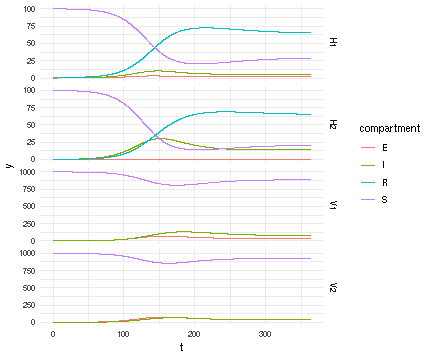

RCall.RObject{RCall.VecSxp}


In [6]:
using RCall
# current version RCall supports better transfers, which would simplify this mess
# but requires Julia v >= 0.7
vals = mlt[:value]
tstamps = mlt[:timestamp]
fcts = mlt[:facet]
comps = mlt[:compartment]
@rput vals tstamps fcts comps
R"
library(ggplot2)
suppressPackageStartupMessages(library(data.table))
dt <- data.table(t=tstamps, y=vals, species=fcts, compartment=comps)
ggplot(dt) + aes(x=t, y=y, color=compartment) + facet_grid(species ~ ., scale = 'free_y') +
  theme_minimal() +
  geom_line()
"